In [1]:
!pip install matplotlib numpy opencv-python tensorflow scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt

In [3]:
# Define dataset paths
dataset_path = r"C:\Users\ASUS\Desktop\University\sem-4\FER2013_Sample_100"
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")

# Define noisy dataset paths
noisy_dataset_path = r"C:\Users\ASUS\Desktop\University\sem-4\FER2013_Sample_100_Noisy_Images"
noisy_train_path = os.path.join(noisy_dataset_path, "train")
noisy_test_path = os.path.join(noisy_dataset_path, "test")

# Ensure noisy dataset directories exist
for path in [noisy_train_path, noisy_test_path]:
    if not os.path.exists(path):
        os.makedirs(path)

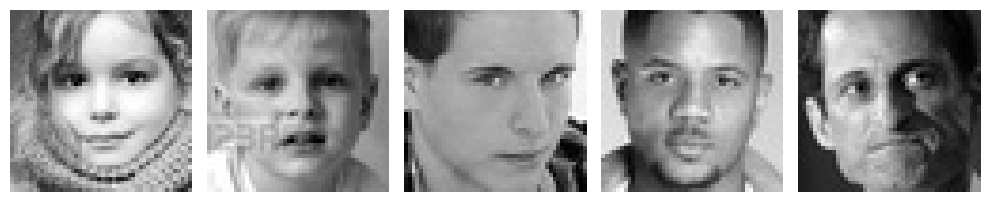

In [4]:
def display_sample_images(folder_path, num_images=5):
    categories = os.listdir(folder_path)
    fig, axes = plt.subplots(len(categories), num_images, figsize=(10, 10))

    # for i, category in enumerate(categories):
    #     category_path = os.path.join(folder_path, category)
    #     image_files = os.listdir(category_path)[:num_images]

    #     for j, image_file in enumerate(image_files):
    #         img_path = os.path.join(category_path, image_file)
    #         img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
    #         img = cv2.resize(img, (48, 48)) 

    #         axes[i, j].imshow(img, cmap='gray')
    #         axes[i, j].axis("off")

    #     axes[i, 0].set_ylabel(category, fontsize=12)

    category_path = os.path.join(folder_path, "neutral")
    image_files = os.listdir(category_path)[:num_images]

    for j, image_file in enumerate(image_files):
        img_path = os.path.join(category_path, image_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
        img = cv2.resize(img, (48, 48)) 
        
        axes[j].imshow(img, cmap='gray')
        axes[j].axis("off")

    axes[0].set_ylabel("neutral", fontsize=12)

    plt.tight_layout()
    plt.show()

display_sample_images(train_path, num_images=5)


In [5]:
from tqdm import tqdm

# Function to add Gaussian noise
def add_gaussian_noise(image, mean=0, std=0.05):  
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = 255*(image + noise)
    # noisy_image = cv2.add(image, noise)  # Add noise to the image
    return noisy_image

# Function to process images and save noisy versions
def process_images(input_folder, output_folder, category="neutral"):
    category_path = os.path.join(input_folder, category)
    noisy_category_path = os.path.join(output_folder, category)

    # Ensure category subfolder exists in noisy images
    if not os.path.exists(noisy_category_path):
        os.makedirs(noisy_category_path)

    # Process images inside category folder
    for img_name in tqdm(os.listdir(category_path), desc=f"Processing {category} in {output_folder}"):
        img_path = os.path.join(category_path, img_name)
        noisy_img_path = os.path.join(noisy_category_path, img_name)

        # Read and process image
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue  # Skip unreadable images
            
        noisy_image = add_gaussian_noise(image/255.0)

        # Save noisy image
        cv2.imwrite(noisy_img_path, noisy_image)

# Apply noise to both train and test datasets for neutral category
process_images(train_path, noisy_train_path, category="neutral")
process_images(test_path, noisy_test_path, category="neutral")

print("✅ Noisy images successfully generated and saved in 'FER2013_Noisy_Images' folder.")

Processing neutral in C:\Users\ASUS\Desktop\University\sem-4\FER2013_Sample_100_Noisy_Images\train: 100%|█| 100/100 [00
Processing neutral in C:\Users\ASUS\Desktop\University\sem-4\FER2013_Sample_100_Noisy_Images\test: 100%|█| 25/25 [00:00

✅ Noisy images successfully generated and saved in 'FER2013_Noisy_Images' folder.


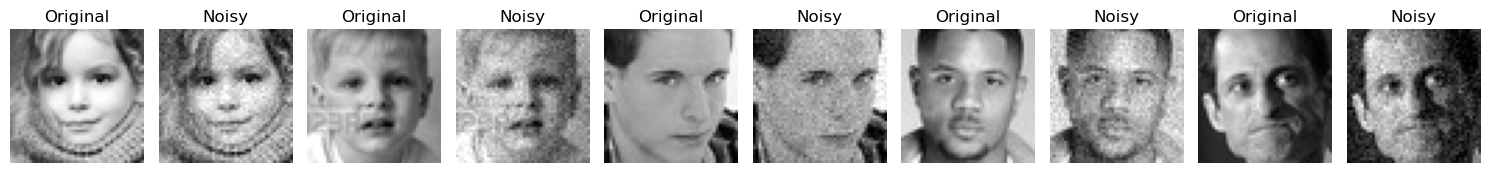

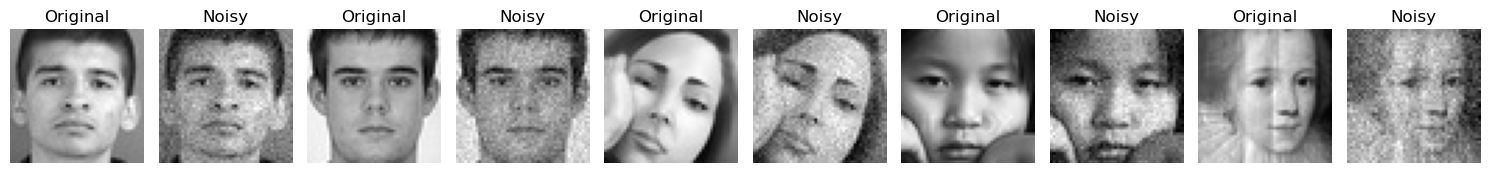

In [6]:
def display_original_and_noisy_images(original_folder, noisy_folder, num_images=5, category="neutral"):
    original_category_path = os.path.join(original_folder, category)
    noisy_category_path = os.path.join(noisy_folder, category)

    if not os.path.exists(noisy_category_path):
        print(f"Skipping {category}, noisy folder not found.")
        return

    fig, axes = plt.subplots(1, num_images * 2, figsize=(15, 5))

    image_files = os.listdir(original_category_path)[:num_images]

    for j, image_file in enumerate(image_files):
        original_img_path = os.path.join(original_category_path, image_file)
        noisy_img_path = os.path.join(noisy_category_path, image_file)

        original_img = cv2.imread(original_img_path, cv2.IMREAD_GRAYSCALE)
        noisy_img = cv2.imread(noisy_img_path, cv2.IMREAD_GRAYSCALE)

        if original_img is None or noisy_img is None:
            continue  # Skip if images are unreadable

        original_img = cv2.resize(original_img, (48, 48))
        noisy_img = cv2.resize(noisy_img, (48, 48))

        # Show original image
        axes[j * 2].imshow(original_img, cmap='gray')
        axes[j * 2].axis("off")
        axes[j * 2].set_title("Original")

        # Show noisy image
        axes[j * 2 + 1].imshow(noisy_img, cmap='gray')
        axes[j * 2 + 1].axis("off")
        axes[j * 2 + 1].set_title("Noisy")

    plt.tight_layout()
    plt.show()

# Display original and noisy images for neutral category
display_original_and_noisy_images(train_path, noisy_train_path, num_images=5, category="neutral")
display_original_and_noisy_images(test_path, noisy_test_path, num_images=5, category="neutral")

In [7]:
def image_to_fft(image):
    fft_transform = np.fft.fft2(image)
    fft_shifted = np.fft.fftshift(fft_transform)
    magnitude = np.abs(fft_shifted)
    phase = np.angle(fft_shifted)
    return np.log1p(magnitude), phase  # Log transformation for stability

# Convert FFT magnitude & phase back to image
def fft_to_image(magnitude, phase):
    magnitude = np.expm1(magnitude)  # Undo log transformation
    fft_reconstructed = np.fft.ifftshift(magnitude * np.exp(1j * phase))
    image_reconstructed = np.fft.ifft2(fft_reconstructed)
    return np.abs(image_reconstructed)

In [8]:
# Load images and apply FFT
def load_images_fft(folder_path, category="neutral", image_size=(48, 48)):
    magnitude_list, phase_list = [], []
    category_path = os.path.join(folder_path, category)
    
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, image_size) / 255.0  # Normalize
        magnitude, phase = image_to_fft(img)
        magnitude_list.append(magnitude)
        phase_list.append(phase)

    return np.array(magnitude_list).astype("float32"), np.array(phase_list).astype("float32")

# Load clean and noisy images as FFT
X_noisy_mag, X_noisy_phase = load_images_fft(noisy_train_path, category="neutral")
X_clean_mag, X_clean_phase = load_images_fft(train_path, category="neutral")

print("FFT Transformed Images Loaded Successfully!")

FFT Transformed Images Loaded Successfully!


In [9]:
# Build Denoising Autoencoder (FFT Version)
def build_fft_dae():
    input_fft = Input(shape=(48, 48, 1))

    # Encoder
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(input_fft)
    x = MaxPooling2D((2, 2), padding="same")(x)

    # Decoder
    x = Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x)
    x = UpSampling2D((2, 2))(x)

    output_fft = Conv2D(1, (3, 3), activation="linear", padding="same")(x)

    model = Model(input_fft, output_fft)
    model.compile(optimizer="adam", loss="mse")
    
    return model

# Train the model using FFT magnitude
dae_fft = build_fft_dae()
dae_fft.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,145 (149.00 KB)

 Trainable params: 38,145 (149.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
best_val_loss = float("inf")

dae_fft = build_fft_dae()
initial_weights = dae_fft.get_weights()

for train_idx, val_idx in kf.split(X_noisy_mag):
    X_train_fold, X_val_fold = X_noisy_mag[train_idx], X_noisy_mag[val_idx]
    y_train_fold, y_val_fold = X_clean_mag[train_idx], X_clean_mag[val_idx]

    dae_fft.set_weights(initial_weights)

    checkpoint = ModelCheckpoint("temp_best_fft_model.keras", monitor="val_loss", save_best_only=True, verbose=0)
    history = dae_fft.fit(X_train_fold, y_train_fold, epochs=500, batch_size=16,
                          validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint], verbose=0)

    dae_fft.load_weights("temp_best_fft_model.keras")
    val_loss = min(history.history["val_loss"])

    if val_loss < best_val_loss:21
        best_val_loss = val_loss
        dae_fft.save("best_fft_dae_model.keras")

print("Best FFT Model Saved!")

Best FFT Model Saved!


In [11]:
# Load the best model
best_fft_model = load_model("best_fft_dae_model.keras")

# Load unseen test images (FFT format)
X_unseen_mag, X_unseen_phase = load_images_fft(noisy_test_path, category="neutral")
y_unseen_mag, y_unseen_phase = load_images_fft(test_path, category="neutral")

# Predict denoised FFT magnitude
denoised_mag = best_fft_model.predict(X_unseen_mag)

# Convert back to spatial domain images
denoised_images = np.array([fft_to_image(denoised_mag[i], X_unseen_phase[i]) for i in range(len(denoised_mag))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


In [12]:
print(f"Shape of y_unseen_mag: {y_unseen_mag.shape}")
print(f"Shape of denoised_mag: {denoised_mag.shape}")


Shape of y_unseen_mag: (25, 48, 48)
Shape of denoised_mag: (25, 48, 48, 1)


In [21]:
def calculate_metrics(original, denoised):
    metrics = {"MSE": [], "PSNR": [], "SSIM": []}
    for i in range(original.shape[0]):
        orig, denoised_img = original[i], denoised[i]
        mse_value = np.mean((orig - denoised_img) ** 2)
        psnr_value = psnr(orig, denoised_img, data_range=orig.max() - orig.min())
        ssim_value = ssim(orig, denoised_img, data_range=orig.max() - orig.min())
        metrics["MSE"].append(mse_value)
        metrics["PSNR"].append(psnr_value)
        metrics["SSIM"].append(ssim_value)
    return {key: np.mean(values) for key, values in metrics.items()}

if y_unseen_mag.shape != denoised_mag.shape:
    denoised_mag = np.resize(denoised_mag, y_unseen_mag.shape)

denoised_metrics = calculate_metrics(y_unseen_mag, denoised_mag)
print("Denoised Image Metrics for Original Images and Denoised Images:", denoised_metrics)

denoised_metrics = calculate_metrics(y_unseen_mag, X_unseen_mag)
print("Denoised Image Metrics for Original and Noisy Images:", denoised_metrics)

Denoised Image Metrics for Original Images and Denoised Images: {'MSE': 0.10218107, 'PSNR': 26.697503936198395, 'SSIM': 0.6132563628060342}
Denoised Image Metrics for Original and Noisy Images: {'MSE': 0.2940455, 'PSNR': 22.184076521396136, 'SSIM': 0.5616085565684855}


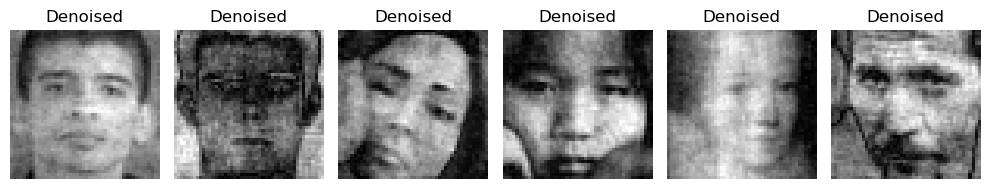

In [19]:
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 6, i + 1)
    img = fft_to_image(denoised_mag[i], X_unseen_phase[i])
    img = np.squeeze(img)  # Ensure it's (48, 48)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Denoised")
plt.tight_layout()
plt.show()

In [16]:
def load_images(folder_path, category="neutral", image_size=(48, 48)):
    data = []
    category_path = os.path.join(folder_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, image_size)
        data.append(img)
    return np.array(data).astype("float32") / 255.0  # Normalize images

# Load noisy and clean images for the "neutral" category
X_noisy = load_images(noisy_train_path, category="neutral")
X_clean = load_images(train_path, category="neutral")

print("Images Loaded successfully!")

Images Loaded successfully!
